In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'./genres/{g}'):
        songname = f'./genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

D:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


<Figure size 720x720 with 0 Axes>

# Extracting features from Spectrogram


Mel-frequency cepstral coefficients (MFCC)(20 in number)  
Spectral Centroid,  
Zero Crossing Rate  
Chroma Frequencies  
Spectral Roll-off.  

In [4]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

# Writing data to csv file

In [17]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./genres/{g}'):
        songname = f'./genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        rmse=librosa.feature.rmse(y=y)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [18]:
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.au,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596742,121.557302,-19.158825,...,8.810668,-3.667367,5.751690,-5.162761,0.750947,-1.691937,-0.409954,-2.300208,1.219928,blues
1,blues.00001.au,0.340983,0.095918,1529.835316,2038.617579,3548.820207,0.056044,-207.556796,124.006717,8.930562,...,5.376802,-2.239119,4.216963,-6.012273,0.936109,-0.716537,0.293875,-0.287431,0.531573,blues
2,blues.00002.au,0.363603,0.175573,1552.481958,1747.165985,3040.514948,0.076301,-90.754394,140.459907,-29.109965,...,5.789265,-8.905224,-1.083720,-9.218359,2.455805,-7.726901,-1.815724,-3.433434,-2.226821,blues
3,blues.00003.au,0.404779,0.141191,1070.119953,1596.333948,2185.028454,0.033309,-199.431144,150.099218,5.647594,...,6.087676,-2.476420,-1.073890,-2.874777,0.780976,-3.316932,0.637981,-0.619690,-3.408233,blues
4,blues.00004.au,0.308590,0.091563,1835.494603,1748.362448,3580.945013,0.101500,-160.266031,126.198800,-35.605448,...,-2.806385,-6.934122,-7.558619,-9.173552,-4.512166,-5.453538,-0.924162,-4.409333,-11.703781,blues


In [19]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

In [20]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [21]:

scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [22]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
import os
import numpy as np
import time
import copy
from glob import glob

import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.autograd import Variable
import random


In [26]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),    
}
data_dir="./img_data1/"
batch_size = 20
num_workers = 0
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'valid', 'test']}
    
loaders_data = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size,
                                              shuffle = True, num_workers = num_workers)
                  for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes
n_classes = len(class_names)

#Check if gpu support is available
use_cuda = torch.cuda.is_available()

In [27]:
print(f"No. of Training Records: {dataset_sizes['train']}")
print(f"No. of Validation Records: {dataset_sizes['valid']}")
print(f"No. of Testing Records: {dataset_sizes['test']}")      
print(f"No. of Classes: {n_classes}")
      

No. of Training Records: 810
No. of Validation Records: 91
No. of Testing Records: 100
No. of Classes: 10


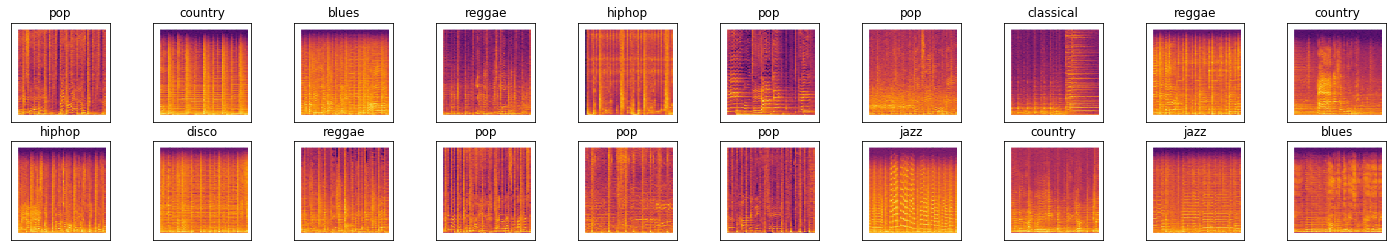

In [33]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)    
    plt.imshow(inp)
    
# Get a batch of training data
images, classes = next(iter(loaders_data['train']))
      
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(class_names[classes[idx]].split(".")[0])

In [34]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1 )        
        # convolutional layer (sees 112x112x16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        # convolutional layer (sees 56x56x32 image tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        # convolutional layer (sees 28x28x64 image tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)        
        # convolutional layer (sees 14x14x128 image tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1 )
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)
        
        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)
        
        # linear layer (256 * 7 * 7 -> 512)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        # linear layer (256 * 7 * 7 -> n_classes (133))
        self.fc2 = nn.Linear(512, n_classes)
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv_bn2(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv_bn3(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.conv_bn4(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.conv_bn5(x)
        x = self.pool(F.relu(self.conv5(x)))
        x = self.conv_bn6(x)
        
        # flatten image input
        x = x.view(-1, 256 * 7 * 7)        
        # add dropout layer
        x = self.dropout(x)
        # add second hidden layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print (model_scratch)

# check if CUDA is available
use_cuda = torch.cuda.is_available()
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2)
  (conv_bn1): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn6): BatchNorm2d(2

In [35]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

In [36]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + (1 / (batch_idx + 1)) * (loss.data - train_loss)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [38]:
# train the model
n_epochs = 25
loaders_scratch = loaders_data
model_scratch = train(n_epochs, loaders_scratch, model_scratch, optimizer_scratch,
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
#model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 1.245627 	Validation Loss: 1.728422
Validation loss decreased (inf --> 1.728422).  Saving model ...
Epoch: 2 	Training Loss: 1.094627 	Validation Loss: 1.564051
Validation loss decreased (1.728422 --> 1.564051).  Saving model ...
Epoch: 3 	Training Loss: 0.929220 	Validation Loss: 1.585991
Epoch: 4 	Training Loss: 0.816269 	Validation Loss: 1.707123
Epoch: 5 	Training Loss: 0.682721 	Validation Loss: 1.606887
Epoch: 6 	Training Loss: 0.529784 	Validation Loss: 1.675036
Epoch: 7 	Training Loss: 0.397663 	Validation Loss: 1.526663
Validation loss decreased (1.564051 --> 1.526663).  Saving model ...
Epoch: 8 	Training Loss: 0.302238 	Validation Loss: 1.572506
Epoch: 9 	Training Loss: 0.205911 	Validation Loss: 1.522934
Validation loss decreased (1.526663 --> 1.522934).  Saving model ...
Epoch: 10 	Training Loss: 0.159535 	Validation Loss: 1.658658
Epoch: 11 	Training Loss: 0.131186 	Validation Loss: 1.564651
Epoch: 12 	Training Loss: 0.099809 	Validation Loss: 1.4

In [40]:

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))


    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [41]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 1.560825


Test Accuracy: 43% (43/100)


# using Transfer Learning

In [42]:
model_transfer = models.densenet161(pretrained=True)
for param in model_transfer.parameters():
    param.requires_grad = False
num_ftrs = model_transfer.classifier.in_features
model_transfer.classifier = nn.Linear(num_ftrs, n_classes)

# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer.cuda()
print(model_transfer)

D:\Anaconda\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to C:\Users\Administrator/.torch\models\densenet161-8d451a50.pth
100%|██████████████████████████████████████████████████████████████| 115730790/115730790 [00:07<00:00, 16443728.99it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

)


In [43]:
criterion_transfer = nn.CrossEntropyLoss()


optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001, momentum=0.9)


In [46]:
# train the model
n_epochs = 50
loaders_transfer = loaders_data
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


Epoch: 1 	Training Loss: 0.769781 	Validation Loss: 1.549224
Validation loss decreased (inf --> 1.549224).  Saving model ...
Epoch: 2 	Training Loss: 0.783689 	Validation Loss: 1.513413
Validation loss decreased (1.549224 --> 1.513413).  Saving model ...
Epoch: 3 	Training Loss: 0.725606 	Validation Loss: 1.597718
Epoch: 4 	Training Loss: 0.739302 	Validation Loss: 1.534771
Epoch: 5 	Training Loss: 0.690332 	Validation Loss: 1.525395
Epoch: 6 	Training Loss: 0.686647 	Validation Loss: 1.532760
Epoch: 7 	Training Loss: 0.664370 	Validation Loss: 1.563780
Epoch: 8 	Training Loss: 0.641349 	Validation Loss: 1.527588
Epoch: 9 	Training Loss: 0.646081 	Validation Loss: 1.528345
Epoch: 10 	Training Loss: 0.599281 	Validation Loss: 1.600119
Epoch: 11 	Training Loss: 0.608791 	Validation Loss: 1.601327
Epoch: 12 	Training Loss: 0.582298 	Validation Loss: 1.549126
Epoch: 13 	Training Loss: 0.581178 	Validation Loss: 1.605579
Epoch: 14 	Training Loss: 0.576017 	Validation Loss: 1.607325
Epoch: 1

In [47]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.532520


Test Accuracy: 49% (49/100)
